# Calorie LGBMRegressor w/Processed Data

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import optuna
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.preprocessing import scale
import yaml

# Load Processed Data

In [2]:
folder_path = '../data/raw'
train = pd.read_csv(f'{folder_path}/train.csv')
test = pd.read_csv(f'{folder_path}/test.csv')

    N = list(range(len(train)))
    random.shuffle(N) 
    train=train.iloc[N[0:60000]]

In [3]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df_train, df_test):
    combined_df = pd.concat([df_train, df_test])
    for c in combined_df.columns:
        if combined_df[c].dtype == 'object':
            combined_df[c] = combined_df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(combined_df[c].values))
            combined_df[c] = lbl.transform(combined_df[c].values)
    return combined_df.iloc[:len(df_train)], combined_df.iloc[len(df_train):]

train,test=labelencoder(train, test)

In [4]:
target='Calories'
trainY=train[target]
trainX=train.drop(target,axis=1)
testX=test.drop(target,axis=1)

In [5]:
train_df=trainX
test_df=testX

In [6]:
columns=test_df.columns.tolist()
print(columns)

submit = pd.read_csv(f'{folder_path}/sample_submission.csv')

# submit=pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
print(submit.columns.tolist())

['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
['id', 'Calories']


In [7]:
def create_numeric_feature(input_df):
    use_columns = columns 
    return input_df[use_columns].copy()

In [8]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):
        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [9]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [10]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 43.83it/s]


createcreate_numeric_feature  0.018[s]


100%|██████████| 1/1 [00:00<00:00, 132.68it/s]

createcreate_numeric_feature  0.006[s]


# Model

In [11]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [12]:
def objective(trial,data=trainX,target=trainY):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    
    param =   {
        'lambda_l1': trial.suggest_float('lambda_l1', 0.001, 0.002,log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 6, 12),
        "bagging_freq":  trial.suggest_int('bagging_freq', 3, 5),
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.56, 0.58),
        "feature_fraction": trial.suggest_float('feature_fraction', 0.75, 0.76),
        'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.12),
        "verbosity":  trial.suggest_int('verbosity', 6, 8),  
        "max_depth":  trial.suggest_int('max_depth', 3, 6),  

        #fixed part       
        'random_state': 64, 
        'num_leaves': 64,        
        'objective': 'regression_l1',
        'reg_lambda': 1.,
        'reg_alpha': .1,
        'n_estimators': 100, 
        'colsample_bytree': .5, 
        'min_child_samples': 10,
        'subsample_freq': 3,
        'subsample': .9,
        'importance_type': 'gain', 
    }
    
    model = lgb.LGBMRegressor(**param, verbose=0)      
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)])
    preds = model.predict(test_x)
    score = rmsle(test_y, np.maximum(preds, 0))
    
    return score

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300, show_progress_bar=True)
Best_trial=study.best_trial.params
print(Best_trial)

[I 2025-05-05 11:15:22,604] A new study created in memory with name: no-name-e0e552d4-ba9d-400b-9324-c55d32c49ae4


  0%|          | 0/300 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.0016304129249973308, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0016304129249973308
[LightGBM] [Warning] lambda_l2 is set=10.280537066975821, reg_lambda=1.0 will be ignored. Current value: lambda_l2=10.280537066975821
[LightGBM] [Warning] feature_fraction is set=0.7568944896166637, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7568944896166637
[LightGBM] [Warning] bagging_fraction is set=0.5631630313585645, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5631630313585645
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=3 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] verbosity is set=6, verbose=0 will be ignored. Current value: verbosity=6
[LightGBM] [Warning] lambda_l1 is set=0.0016304129249973308, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0016304129249973308
[LightGBM] [Warning] lambda_l2 is set=10.280537066975821, reg_lambda=1.0 will be ign

Exception ignored on calling ctypes callback function: <function _log_callback at 0x135d0f380>
Traceback (most recent call last):
  File "/Users/cbutler/repos/personal_repos/KAGGLE_S5E5/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 60 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 52 and depth = 6
[LightGBM] [Debug] Re-bagging, using 345265 data to train
No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 6
[LightGBM] [Debug] Re-bagging, using 345950 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 57 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 52 and depth = 6
[LightGBM]

/var/folders/ph/4n426_w151s3mcqb32z08qq00000gn/T/ipykernel_4492/1728378831.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  display(vis_matplotlib.plot_optimization_history(study))


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

/var/folders/ph/4n426_w151s3mcqb32z08qq00000gn/T/ipykernel_4492/1728378831.py:6: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  display(vis_matplotlib.plot_slice(study))


array([<Axes: xlabel='bagging_fraction', ylabel='Objective Value'>,
       <Axes: xlabel='bagging_freq'>, <Axes: xlabel='feature_fraction'>,
       <Axes: xlabel='lambda_l1'>, <Axes: xlabel='lambda_l2'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='max_depth'>,
       <Axes: xlabel='verbosity'>], dtype=object)

/var/folders/ph/4n426_w151s3mcqb32z08qq00000gn/T/ipykernel_4492/1728378831.py:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  display(vis_matplotlib.plot_param_importances(study))


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

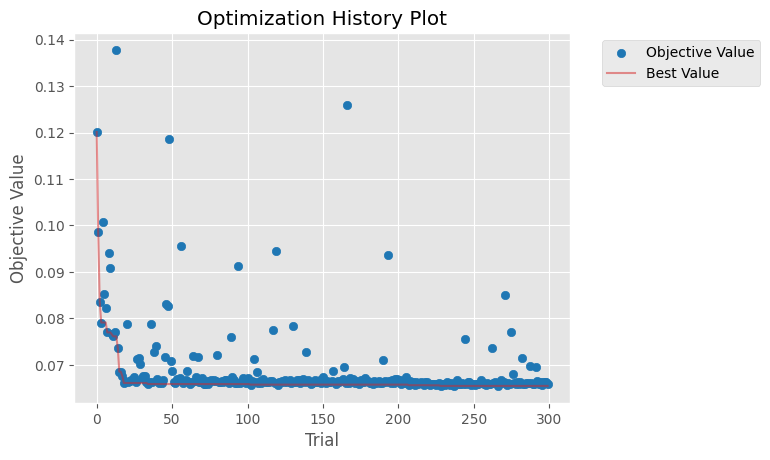

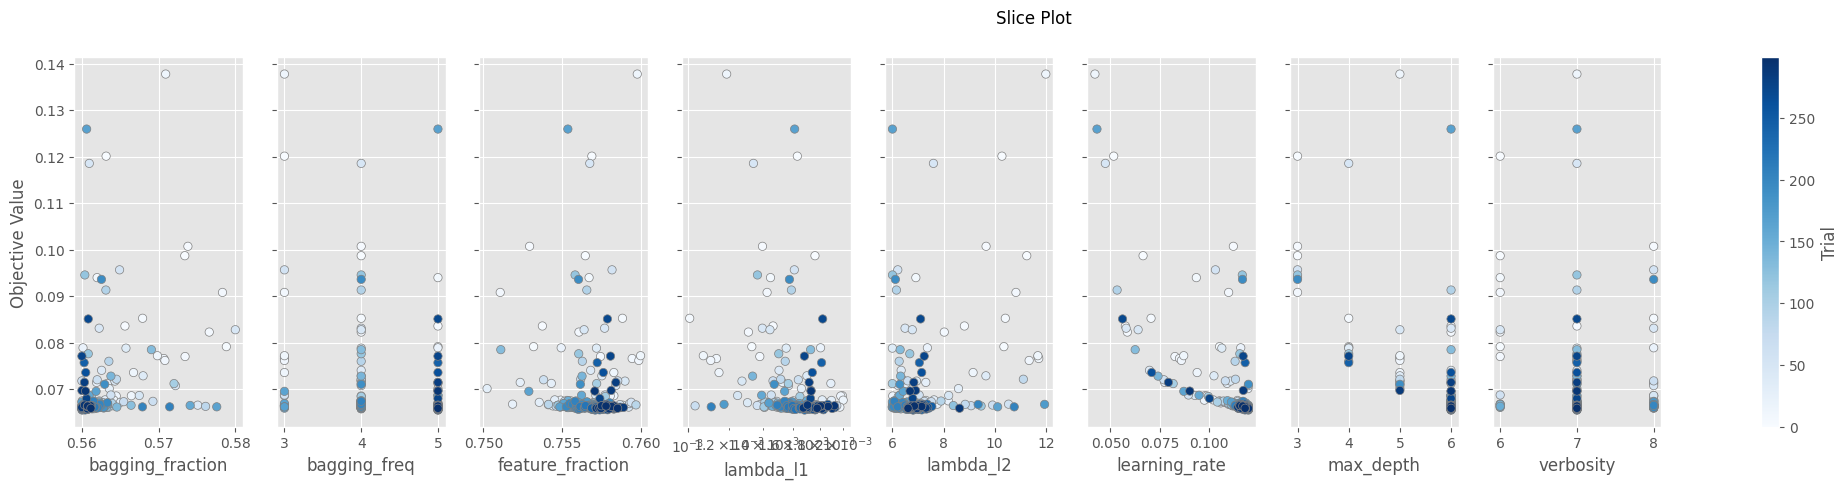

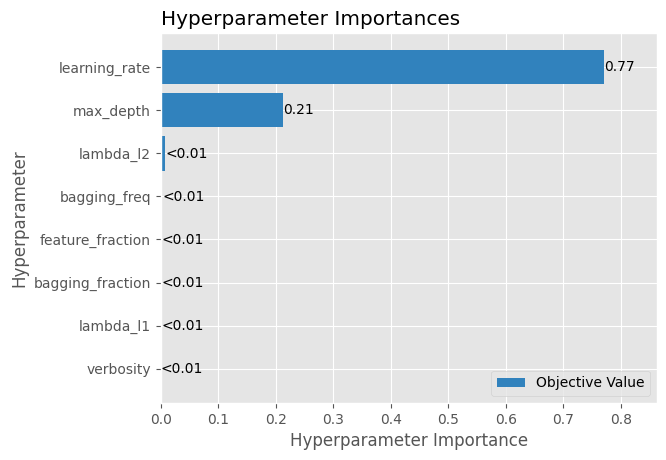

In [14]:
import optuna
import optuna.visualization.matplotlib as vis_matplotlib
import matplotlib.pyplot as plt

display(vis_matplotlib.plot_optimization_history(study))
display(vis_matplotlib.plot_slice(study))
display(vis_matplotlib.plot_param_importances(study))

In [15]:
train=trainX
target=trainY
test=testX

In [16]:
Best_trial=study.best_trial.params

fix_dict =  {        
    'random_state': 64, 
    'num_leaves': 64,        
    'objective': 'regression_l1',
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'n_estimators': 100, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
}

Best_trial.update(fix_dict)

In [20]:
preds = np.zeros((submit.shape[0]))

X_tr,X_val=train[columns],train[columns]
y_tr,y_val=target,target

model = lgb.LGBMRegressor(**Best_trial)
model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)])
preds = model.predict(test[columns])

oof_pred=model.predict(X_val)
score = rmsle(y_val, np.maximum(oof_pred, 0))
print(score)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0016838659225225001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0016838659225225001
[LightGBM] [Warning] lambda_l2 is set=6.816048559942313, reg_lambda=1.0 will be ignored. Current value: lambda_l2=6.816048559942313
[LightGBM] [Warning] bagging_fraction is set=0.5600550938420944, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5600550938420944
[LightGBM] [Warning] feature_fraction is set=0.7571066302658794, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7571066302658794
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0016838659225225001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0016838659225225001
[LightGBM] [Warning] lambda_l2 is set=6.816048559942313, reg_lambda=1.0 w

In [21]:
submit.iloc[:,1]= preds
submit.to_csv('../submissions/online_notebook_submission_kfold_removed.csv',index=False)
display(submit)

id    Calories
0       750000   28.084386
1       750001  106.217289
2       750002   89.439675
3       750003  128.034056
4       750004   76.072044
...        ...         ...
249995  999995   25.430277
249996  999996    8.875805
249997  999997   73.219765
249998  999998  169.209863
249999  999999   75.447896

[250000 rows x 2 columns]

![](https://www.kaggle.com/competitions/91716/images/header)